<a href="https://colab.research.google.com/github/udayLab/PAMI/blob/main/notebooks/weightedFrequentRegularPatterns/basic/WFRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Weighted Frequent Regular Patterns in Temporal Databases using WFRIM

This tutorial has two parts. In the first part, we describe the basic approach to find Weighted Frequent Regular Patterns in a temporal database using the WFRIM algorithm. In the final part, we describe an advanced approach, where we evaluate the WFRIM algorithm on a dataset at different minimum support threshold values.
***

# Prerequisites:

1.   Installing the PAMI library

In [1]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.9/883.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 16.2 MB/s eta 0:00:00
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=0a284deade0b5450193488c91825c38d21b051845204b863baa50fd26fca1597
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4753 sha256=81d1e1f30b40f6cc7e27bcb298be22eb1e04c5fa3ecd846426f5a5f1f0ab023d
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv #download a sample temporal database

--2023-11-16 16:10:02--  https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.31.244.160, 150.95.161.176
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.31.244.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4606762 (4.4M) [text/csv]
Saving to: ‘Temporal_T10I4D100K.csv’

Temporal_T10I4D100K 100%[===================>]   4.39M  1.15MB/s    in 6.0s    

2023-11-16 16:10:10 (749 KB/s) - ‘Temporal_T10I4D100K.csv’ saved [4606762/4606762]



3.   Printing few lines of a dataset to know its format.

In [3]:
!head -2 Temporal_T10I4D100K.csv

1	25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
2	39	120	124	205	401	581	704	814	825	834


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding Weighted Frequent Regular Patterns using WFRIM

### Step 1: Understanding the statistics of a database to choose an appropriate minimum support (minSup) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.TemporalDatabase as stats

#specify the file name
inputFile = 'Temporal_T10I4D100K.csv'

#initialize the class
obj=stats.TemporalDatabase(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99913
Total number of items : 870
Database sparsity : 0.9883887027691103
Minimum Transaction Size : 1
Average Transaction Size : 10.10182859087406
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667115963877195
Variance in Transaction Sizes : 13.447874088362232


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

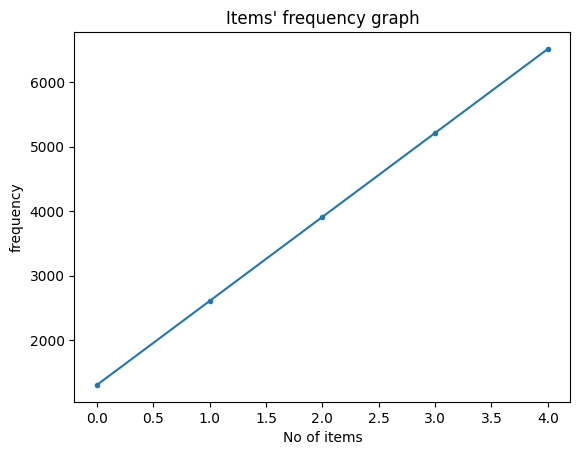

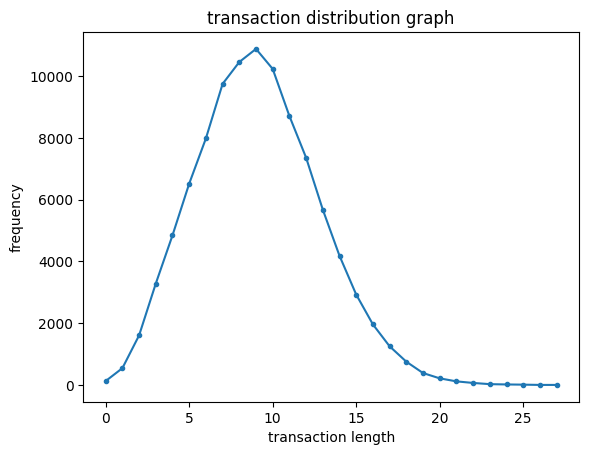

In [5]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 500 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [6]:
minimumSupportCount = 500  #minSup is specified in count. However, the users can also specify minSup between 0 and 1.
weightFile = 'T10_weights.txt'
regularity=3000

### Step 4: Mining Weighted Frequent Regular Patterns using WFRIM

In [7]:
from PAMI.weightedFrequentRegularPattern.basic import WFRIMiner as alg #import the algorithm

obj = alg.WFRIMiner(iFile=inputFile, _wFile=weightFile, WS=minimumSupportCount, regularity=regularity, sep='\t') #initialize
obj.mine()            #start the mining process

obj.save('weightedFrequentRegularPatternsAtMinSupCount500.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Weighted Frequent Regular patterns were generated successfully using WFRIM algorithm
Total No of patterns: 1201
Runtime: 25.564584493637085
Memory (RSS): 613384192
Memory (USS): 590700544


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [8]:
!head 'weightedFrequentRegularPatternsAtMinSupCount500.txt'

609:[184, 2638, 14701.594204892775] 
644:[197, 2997, 16404.561009391855] 
452:[205, 2420, 19117.16199693785] 
89:[211, 2673, 12709.875483117761] 
466:[212, 2321, 18160.54317283448] 
734:[217, 1915, 11051.415491503669] 
902:[222, 2562, 9715.457877147284] 
267:[223, 2262, 4833.587471318886] 
313:[223, 2504, 1906.8641614904022] 
179:[236, 2389, 2170.515800953376] 


The storage format is: _weightedfrequentRegularPattern:support_
***

## Part 2: Evaluating the WFRIM algorithm on a dataset at different minSup values

### Step 1: Import the libraries and specify the input parameters

In [9]:
#Import the libraries
from PAMI.weightedFrequentRegularPattern.basic import WFRIMiner as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Temporal_T10I4D100K.csv'
seperator='\t'
minimumSupportCountList = [100, 200, 300, 400, 500]
weightFile = 'T10_weights.txt'
regularity = 2000
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of WFRIM

In [10]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of WFRIM algorithm

### Step 3: Execute the algorithm at different minSup values

In [11]:
for minSupCount in minimumSupportCountList:
    obj = alg.WFRIMiner(inputFile, _wFile=weightFile, WS=minSupCount, regularity=regularity, sep=seperator)
    obj.mine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['WFRIM', minSupCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Weighted Frequent Regular patterns were generated successfully using WFRIM algorithm
Weighted Frequent Regular patterns were generated successfully using WFRIM algorithm
Weighted Frequent Regular patterns were generated successfully using WFRIM algorithm
Weighted Frequent Regular patterns were generated successfully using WFRIM algorithm
Weighted Frequent Regular patterns were generated successfully using WFRIM algorithm


### Step 4: Print the Result

In [12]:
print(result)

  algorithm  minSup  patterns    runtime     memory
0     WFRIM     100      4649  24.710214  607920128
1     WFRIM     200      4643  23.434430  608448512
2     WFRIM     300      3545  24.234488  609054720
3     WFRIM     400      1987  24.782321  609419264
4     WFRIM     500      1153  25.673576  609087488


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

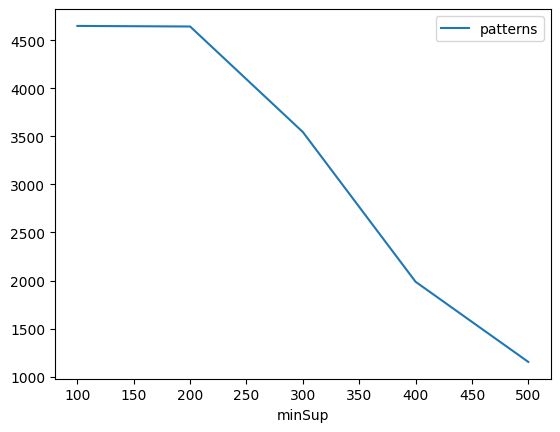

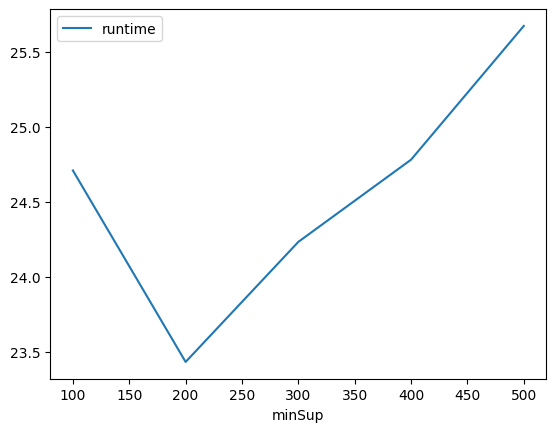

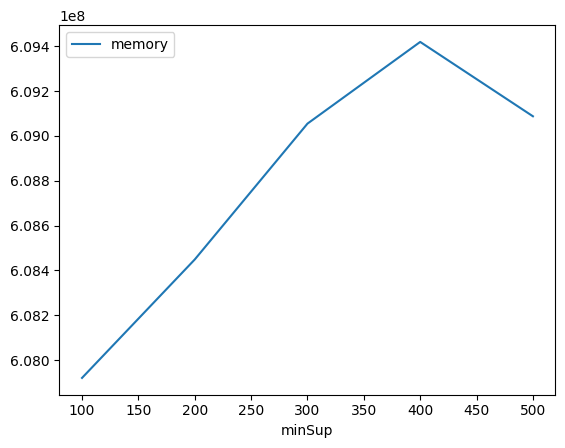

In [13]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib